# Preparación del Dataset GTZAN

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Definir ruta del dataset
general_path = "Data"
data_path = f"{general_path}/genres_original"

# Verificar estructura del dataset
print("Estructura del dataset:")
print(f"Ruta principal: {data_path}")

# Listar géneros disponibles
genres = [genre for genre in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, genre))]
print(f"\nGéneros encontrados: {genres}")
print(f"Total de géneros: {len(genres)}")

# Contar archivos por género
genre_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join(data_path, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    genre_counts[genre] = len(files)
    total_files += len(files)
    print(f"{genre}: {len(files)} archivos")

print(f"\nTotal de archivos: {total_files}")

Estructura del dataset:
Ruta principal: Data/genres_original

Géneros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total de géneros: 10
blues: 100 archivos
classical: 100 archivos
country: 100 archivos
disco: 100 archivos
hiphop: 100 archivos
jazz: 100 archivos
metal: 100 archivos
pop: 100 archivos
reggae: 100 archivos
rock: 100 archivos

Total de archivos: 1000


In [3]:
# Importamos un archivo
sample_y, sample_sr = librosa.load(f'{data_path}/hiphop/hiphop.00033.wav')

In [4]:
def track_by_gender(genre_folder):
    """
    Devuelve la ruta de la pista .wav encontrada en la carpeta del género.
    """
    for f in sorted(os.listdir(genre_folder)):
        if f.endswith(".wav"):
            return os.path.join(genre_folder, f)
    raise FileNotFoundError("No se encontró archivo .wav en " + genre_folder)

## Onda de sonido (Sound Waves)
Representa la amplitud de la señal en el dominio temporal.

Permite ubicar silencios, golpes fuertes, ataques y dinámica general.

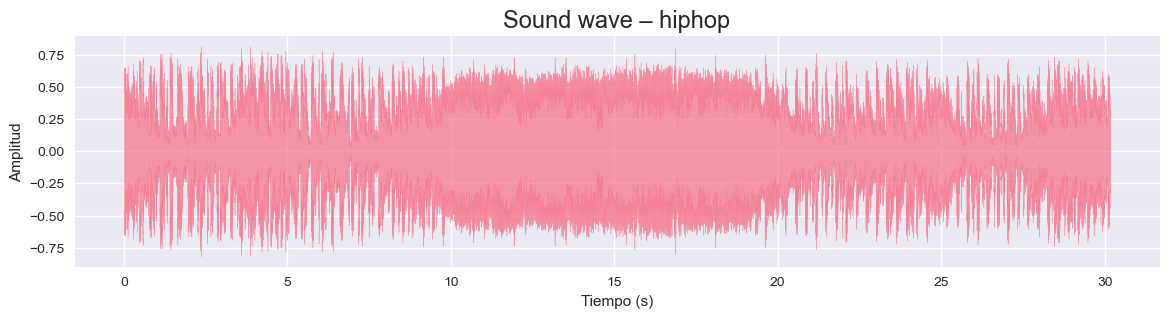

In [5]:
def show_soundwave(y, sr, genre):
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.7)
    plt.title(f"Sound wave – {genre}", fontsize = 17)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()

show_soundwave(sample_y, sample_sr, 'hiphop')

## Short-time Fourier transform (STFT)
Transforma la señal al dominio frecuencia → muestra cuánta energía hay en cada banda.

Ayuda a detectar graves predominantes, presencia de platillos, formantes vocales, etc.

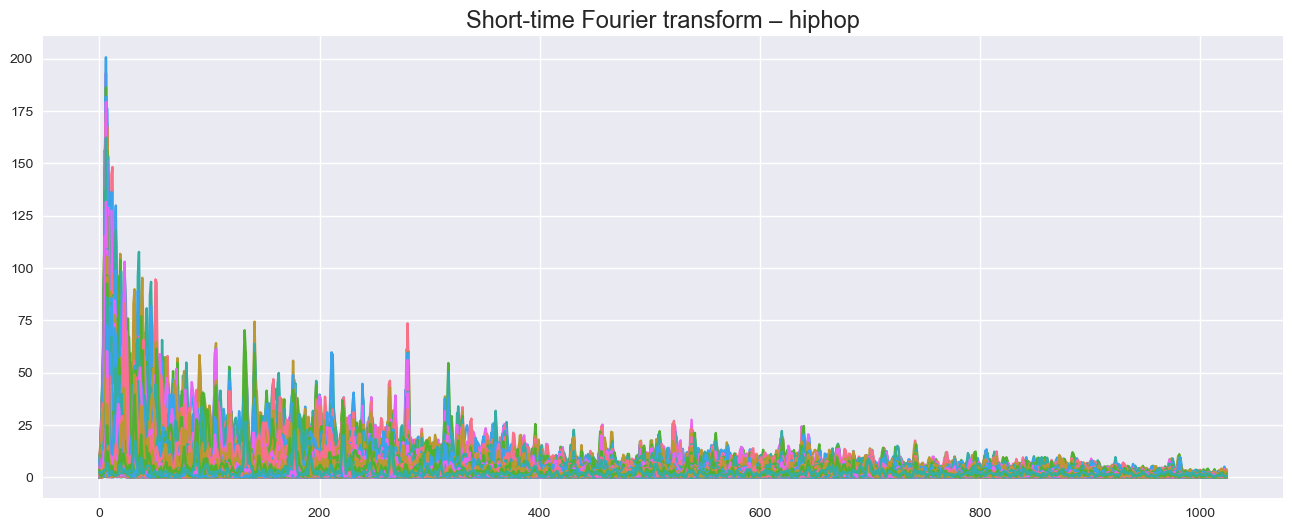

In [6]:
def show_stft(y, genre):
    # FFT simple de toda la señal
    n_fft = 2048 # Tamaño de la ventana FFT
    hop_length = 512 # Número audio de fotogramas entre columnas STFT
    
    audio_file, _ = librosa.effects.trim(y)
    
    D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
    
    plt.figure(figsize = (16, 6))
    plt.title(f"Short-time Fourier transform – {genre}", fontsize = 17)
    plt.plot(D);

show_stft(sample_y, 'hiphop')

## Mel Spectrogram
Espectrograma en escala Mel, aproximando la percepción humana.

Visualiza cómo evoluciona la energía por bandas perceptuales; útil para ver patrones rítmico-armónicos.

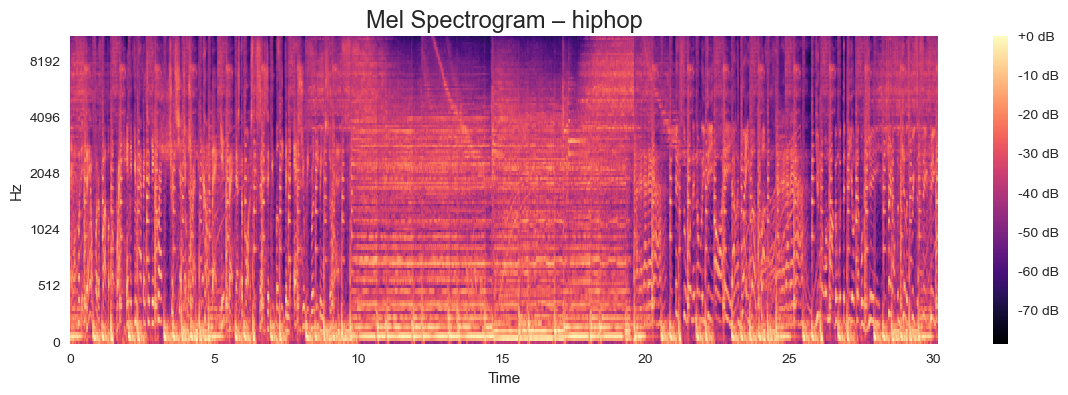

In [7]:
def show_mel_spectogram(y, sr, genre):
    S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128, hop_length = 512)
    S_dB = librosa.power_to_db(S, ref = np.max)
    
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(S_dB, sr = sr, hop_length=512, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram – {genre}", fontsize = 17)
    plt.show()

show_mel_spectogram(sample_y, sample_sr, 'hiphop')

## Zero Crossing Rate
Número de veces que la señal cruza el eje cero por frame.

Diferencia secciones ruidosas/percusivas (alto ZCR) de suaves/tonales (bajo ZCR).

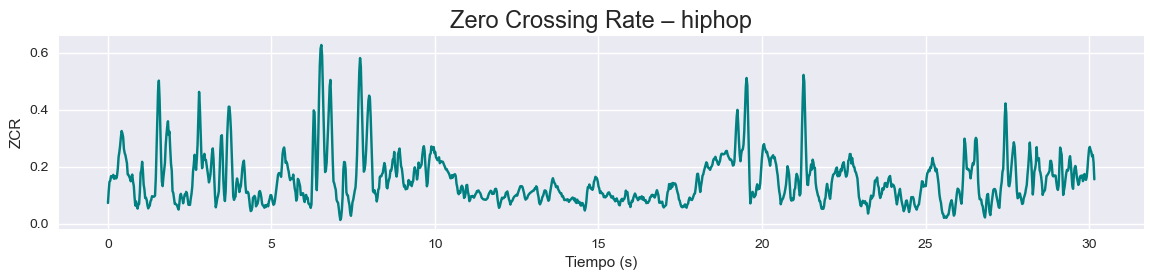

In [8]:
def show_zcr(y, sr, genre):
    zcr = librosa.feature.zero_crossing_rate(y, hop_length = 512)[0]
    times = librosa.times_like(zcr, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 2.5))
    plt.plot(times, zcr, color = 'teal')
    plt.title(f"Zero Crossing Rate – {genre}", fontsize = 17)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("ZCR")
    plt.show()

show_zcr(sample_y, sample_sr, 'hiphop')

## Harmonics and Perceptrual (HPSS)
Separa la señal en parte armónica (tonal, sostenida) y percusiva (transitoria).

Ayuda a estudiar ritmo vs. armonía; revela compases, líneas de bajo, etc.

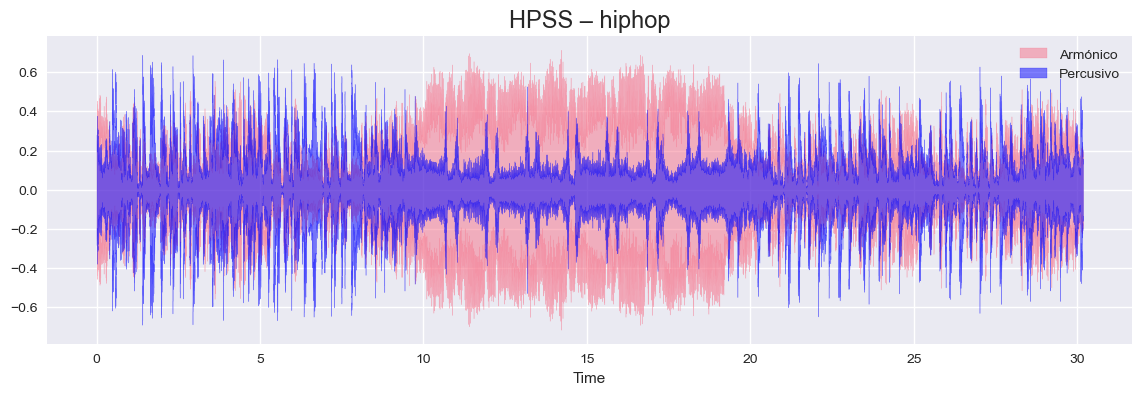

In [9]:
def show_hpss(y, sr, genre):
    harm, perc = librosa.effects.hpss(y)
    
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(harm, sr = sr, alpha=0.5, label = 'Armónico')
    librosa.display.waveshow(perc, sr = sr, color = 'b', alpha=0.5, label = 'Percusivo')
    plt.title(f"HPSS – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_hpss(sample_y, sample_sr, 'hiphop')

## Tempo BMP
Estimación global de BPM y localización de golpes.

Confirma si el género se mueve en rangos típicos (ej.: jazz ≈ 120-180 BPM).

Tempo estimado: 95.7 BPM


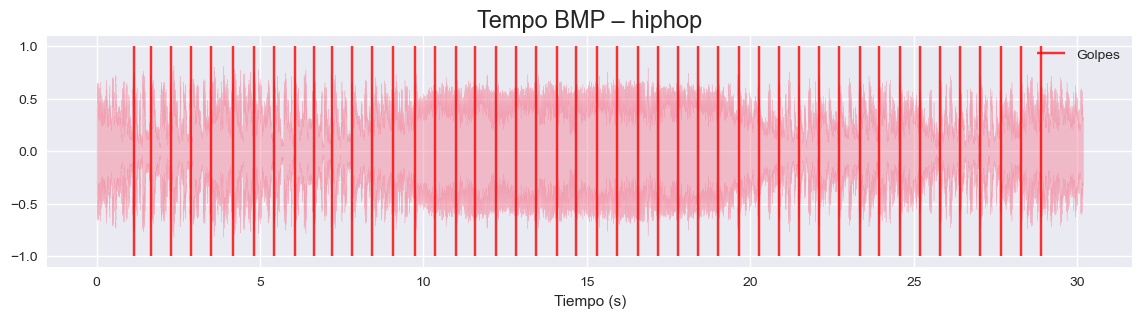

In [10]:
def show_bpm(y, sr, genre):
    # Estimación de tempo (BPM) y beats
    tempo, beats = librosa.beat.beat_track(y = y, sr = sr, units = 'time')
    
    # Si el tempo es un array, lo convertimos a escalar
    if isinstance(tempo, np.ndarray):
        tempo = float(tempo.squeeze())
    
    print(f"Tempo estimado: {tempo:.1f} BPM")
    
    # Visualización del audio y los beats detectados
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.vlines(beats, -1, 1, color = 'red', alpha = 0.8, label = 'Golpes')
    plt.title(f"Tempo BMP – {genre}", fontsize = 17)
    plt.xlabel("Tiempo (s)")
    plt.legend()
    plt.show()

show_bpm(sample_y, sample_sr, 'hiphop')

## Spectral Centroid
“Centro de masas” del espectro por frame (brillo percibido).

Indicador de nitidez/​brillantez: metal ≫ clásica, por ejemplo.

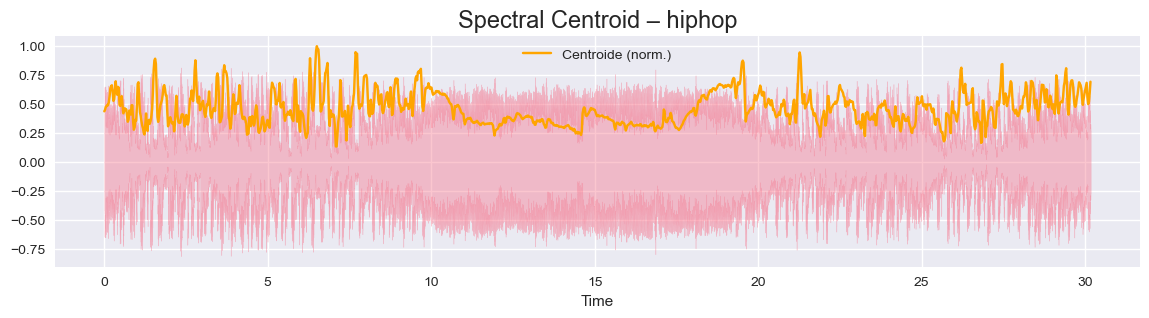

In [11]:
def show_spectral_centroid(y, sr, genre):
    centroid = librosa.feature.spectral_centroid(y = y, sr = sr, hop_length = 512)[0]
    centroid_norm = centroid / centroid.max()            # para escalar en la onda
    times = librosa.times_like(centroid, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, centroid_norm, color = 'orange', label = 'Centroide (norm.)')
    plt.title(f"Spectral Centroid – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_centroid(sample_y, sample_sr, 'hiphop')

## Spectral Rolloff
Frecuencia por debajo de la cual se concentra un porcentaje (85-95%) de la energía.

Distingue señales con mucha energía en agudos (alta rolloff) de graves/​suaves.

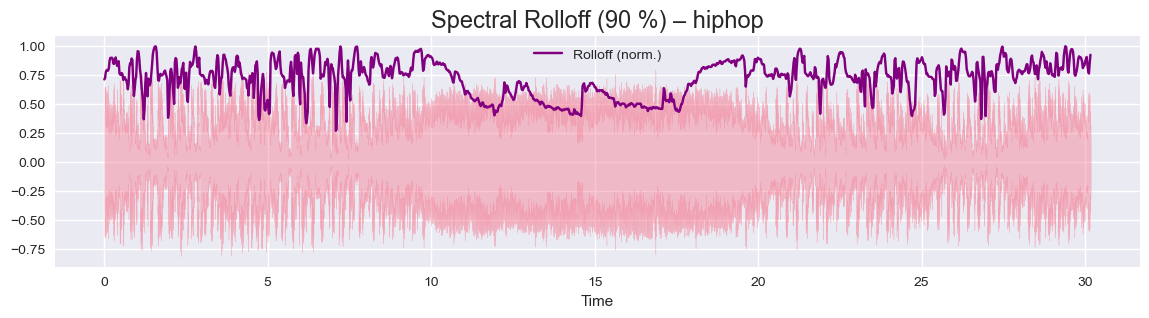

In [12]:
def show_spectral_rolloff(y, sr, genre):
    rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr, hop_length = 512, roll_percent = 0.90)[0]
    rolloff_norm = rolloff / rolloff.max()
    times = librosa.times_like(rolloff, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, rolloff_norm, color = 'purple', label = 'Rolloff (norm.)')
    plt.title(f"Spectral Rolloff (90 %) – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_rolloff(sample_y, sample_sr, 'hiphop')

## MFCC (Mel-Frequency Cepstral Coefficients)
Resumen compacto de la envolvente espectral en escala Mel (timbre).

Muy usados en clasificación de género, identificación de instrumentos y voz.

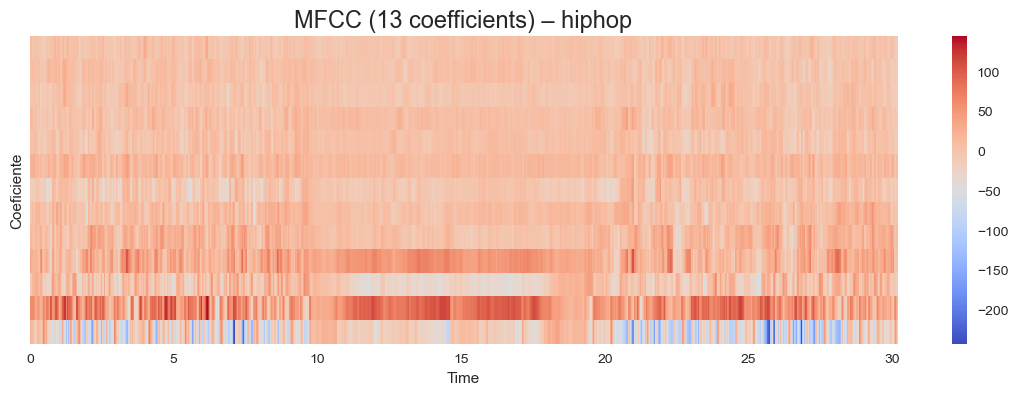

Mean: -9.0288693e-10 

Var: 1.0


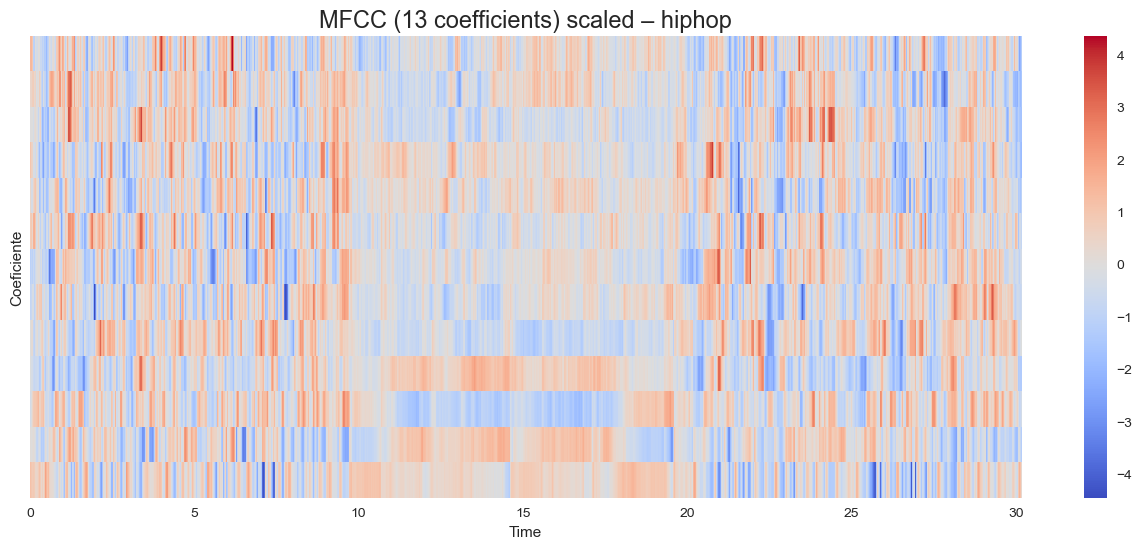

In [13]:
def show_mfcc(y, sr, genre):
    mfcc = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13, hop_length = 512)
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(mfcc, sr = sr, hop_length = 512, x_axis = 'time', cmap = 'coolwarm')
    plt.colorbar()
    plt.title(f"MFCC (13 coefficients) – {genre}", fontsize = 17)
    plt.ylabel("Coeficiente")
    plt.show()

    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    print('Mean:', mfcc.mean(), '\n')
    print('Var:', mfcc.var())
    
    plt.figure(figsize = (16, 6))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'coolwarm')
    plt.colorbar()
    plt.title(f"MFCC (13 coefficients) scaled – {genre}", fontsize = 17)
    plt.ylabel("Coeficiente")
    plt.show()

show_mfcc(sample_y, sample_sr, 'hiphop')

## Chroma Frequencies
Distribución de energía en las 12 clases de altura (C, C♯, D…).

Revela progresiones armónicas independientemente de la octava; útil para detectar tonalidad y acordes.

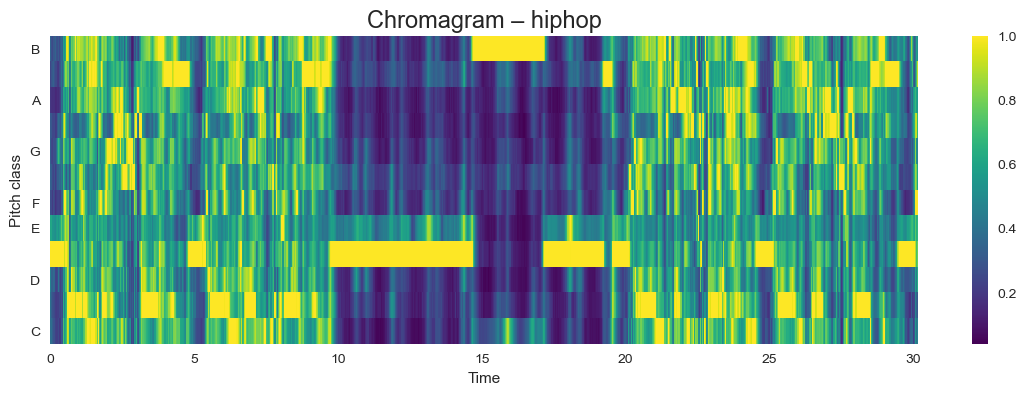

In [14]:
def show_chroma_freq(y, sr, genre):
    chroma = librosa.feature.chroma_cqt(y = y, sr = sr, hop_length = 512)
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(chroma, x_axis = 'time', y_axis = 'chroma', cmap = 'viridis', hop_length = 512)
    plt.colorbar()
    plt.title(f"Chromagram – {genre}", fontsize = 17)
    plt.show()

show_chroma_freq(sample_y, sample_sr, 'hiphop')

In [15]:
def show_genre_graphs(genre):
    audio_path = track_by_gender(os.path.join(data_path, genre))
    y, sr = librosa.load(audio_path, sr = None)
    dur = librosa.get_duration(y = y, sr = sr)
    
    print(f"Género: {genre} | Archivo: {os.path.basename(audio_path)}")
    print(f"Frecuencia de muestreo: {sr} Hz | Duración: {dur:.1f} s")

    show_soundwave(y, sr, genre)

    #show_stft(y, genre)

    show_mel_spectogram(y, sr, genre)

    #show_zcr(y, sr, genre)

    #show_hpss(y, sr, genre)

    #show_bpm(y, sr, genre)

    #show_spectral_centroid(y, sr, genre)

    #show_spectral_rolloff(y, sr, genre)

    #show_mfcc(y, sr, genre)

    #show_chroma_freq(y, sr, genre)

In [16]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

#for genre in genres:
    #show_genre_graphs(genre)

In [17]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


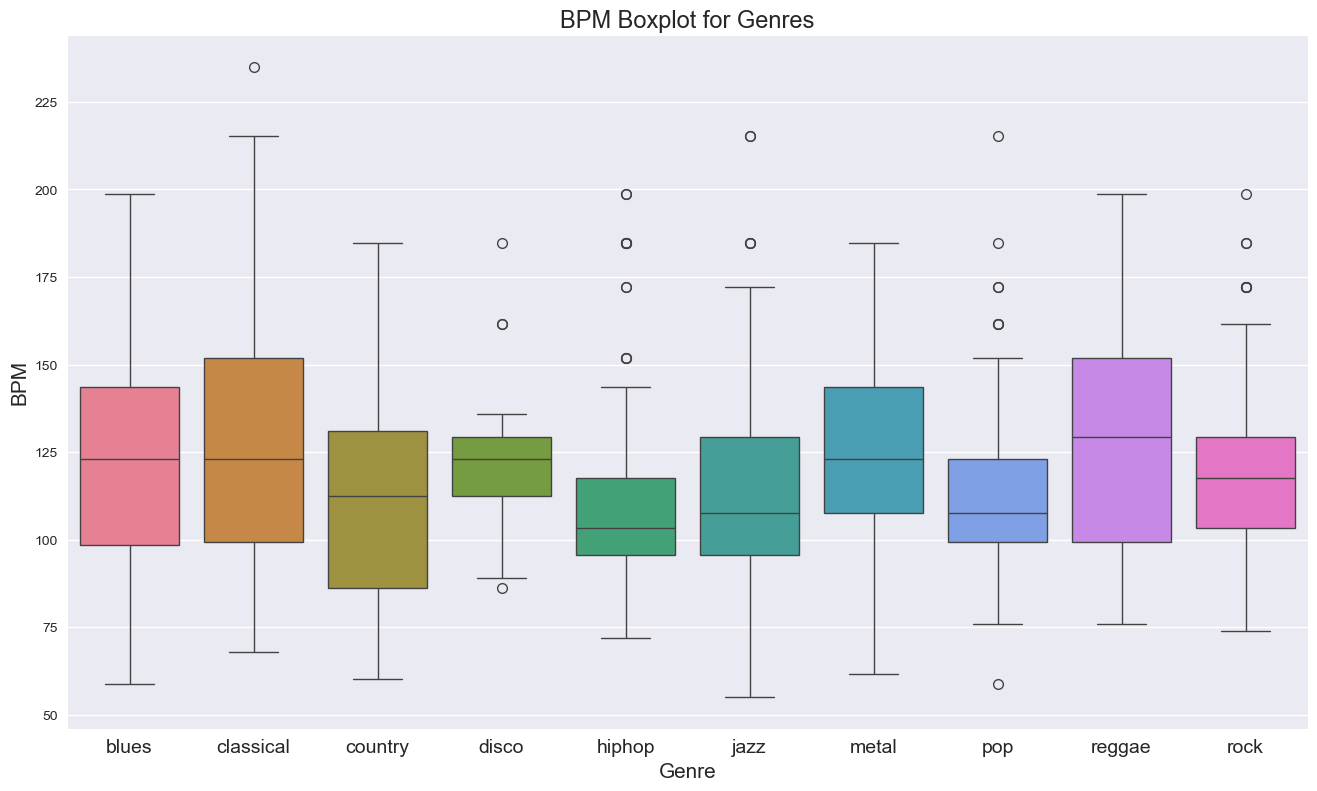

In [18]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize = (16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 17)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")